In [2]:
!pip install deepspeed
!pip install pytorch-gan-metrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 3.5 MB/s eta 0:00:00
  Created wheel for deepspeed: filename=deepspeed-0.15.2-py3-none-any.whl size=1521839 sha256=0c8b927e71d504834654383735afc9aa56c41e57f27dce1188586494c4fefa3b
  Stored in directory: /root/.cache/pip/wheels/53/f1/46/5d54ff3c9f0af8cab280e54887af31c3a6b489b409ba8e3f5c
Successfully built deepspeed


In [4]:
import glob
import os
import shutil

import deepspeed as ds
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as L
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from pytorch_lightning.utilities import CombinedLoader
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torchvision.utils import make_grid, save_image
from torchmetrics import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

_ = L.seed_everything(0, workers=True)

---

# 1. Data Preprocessing

In [6]:
def show_img(img_tensor, nrow, title=""):
    img_tensor = img_tensor.detach().cpu() * 0.5 + 0.5
    img_grid = make_grid(img_tensor, nrow=nrow).permute(1, 2, 0)
    plt.figure(figsize=(18, 8))
    plt.imshow(img_grid)
    plt.axis("off")
    plt.title(title)
    plt.show()

### Augmenting the images.

In [7]:
class CustomTransform(object):
    def __init__(self, load_dim=286, target_dim=256):
        self.transform_train = T.Compose([
            T.Resize((load_dim, load_dim), antialias=True),
            T.RandomCrop((target_dim, target_dim)),
            T.RandomHorizontalFlip(p=0.5),
#             T.ColorJitter(brightness=0.2, contrast=0.2,
#                           saturation=0.2, hue=0.1),
        ])
        
        # ensure images outside of training dataset are also of the same size
        self.transform = T.Resize((target_dim, target_dim), antialias=True)
        
    def __call__(self, img, stage):
        if stage == "fit" or stage == 'validate':
            img = self.transform_train(img)
        else:
            img = self.transform(img)
        return img * 2 - 1

### Storing the datasets.

In [8]:
class CustomDataset(Dataset):
    def __init__(self, filenames, transform, stage):
        self.filenames = filenames
        self.transform = transform
        self.stage = stage
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        try:
            img = read_image(img_name) / 255.0
        except Exception as e:
            print(f"Error reading image: {e}")
            print(f"Image name: {img_name}")
            raise e 
        return self.transform(img, stage=self.stage)

In [9]:

import os
import glob
import torchvision.transforms as T
from PIL import Image
import torch

def load_and_check_image_shape(image_path_pattern):
    # Find all image files matching the pattern
    image_files = glob.glob(image_path_pattern)
    if not image_files:
        print("No images found for pattern:", image_path_pattern)
        return None
    
    # Open the first image
    image_path = image_files[0]
    img = Image.open(image_path)

    # Convert the image to a tensor
    transform = T.ToTensor()  # Converts the image to a tensor and scales to [0, 1]
    tensor_image = transform(img)
    print(f"Shape of image at {image_path}: {tensor_image.shape}")

    # Close the PIL image to free up system resources
    img.close()
    
    return tensor_image


# Paths setup
face_test_dir = os.path.join("/kaggle/working/person-face-sketch/test/sketches", "*.jpg")
sketch_train_dir = os.path.join("/kaggle/input/pretty-face/sketch/sketch", "*.jpg")

# Load and print the shape of one image from each directory
face_test_image = load_and_check_image_shape(face_test_dir)
sketch_train_image = load_and_check_image_shape(sketch_train_dir)

# Optionally show the images (reqauires an environment that supports image display)
# face_test_image.show()  # Uncomment to view the image
# sketch_train_image.show()  # Uncomment to view the image


No images found for pattern: /kaggle/working/person-face-sketch/test/sketches/*.jpg
No images found for pattern: /kaggle/input/pretty-face/sketch/sketch/*.jpg


In [132]:
import os
from PIL import Image
import glob

def convert_grayscale_to_rgb(input_dir, output_dir):
    # Create the output directory if it doesn't already exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # List all JPEG images in the input directory
    image_files = glob.glob(os.path.join(input_dir, "*.jpg"))

    for image_file in image_files:
        # Open the image
        with Image.open(image_file) as img:
            # Check if the image is in grayscale
            if img.mode != 'RGB':
                # Convert the image to RGB
                rgb_img = img.convert('RGB')
                # Prepare the output path
                output_path = os.path.join(output_dir, os.path.basename(image_file))
                # Save the converted image to the output directory
                rgb_img.save(output_path)
                # print(f"Converted and saved: {output_path}")
            else:
                continue
                # print(f"Image already in RGB: {image_file}")

# Example usage:
# Define input and output directories
input_dirs = [
    "/kaggle/input/person-face-sketch/train/sketches",
    "/kaggle/input/person-face-sketch/test/sketches"
]
output_dirs = [
    "/kaggle/output/person-face-sketch/train/sketches",
    "/kaggle/output/person-face-sketch/test/sketches"
]

for input_dir, output_dir in zip(input_dirs, output_dirs):
    convert_grayscale_to_rgb(input_dir, output_dir)


In [ ]:
import os
import glob
from PIL import Image
import shutil

def convert_and_save_images(directory_pattern, output_dir, convert_to_rgb=False):
    # Get all image file paths that match the pattern
    image_files = glob.glob(directory_pattern)
    
    # Sort files to ensure consistent order
    image_files.sort()
    
    # Only process the first 1000 images
    files_to_process = image_files[:1000]
    
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    for file_path in files_to_process:
        try:
            # Open the image
            img = Image.open(file_path)
            
            # Convert the image to RGB if necessary
            if convert_to_rgb and img.mode != 'RGB':
                img = img.convert('RGB')
                print(f"Converted {file_path} to RGB.")
            
            # Get the file name and construct the output path
            file_name = os.path.basename(file_path)
            output_path = os.path.join(output_dir, file_name)
            
            # Save the image to the new directory
            img.save(output_path)
            print(f"Saved {output_path}")
            
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

# Define the source directories (glob patterns for .jpg files) and their output directories
directories = {
    "face_train_dir": {
        "source": os.path.join("/kaggle/input/person-face-sketch/train/photos", "*.jpg"),
        "output": os.path.join("person-face-sketch/train/photos"),
        "convert_to_rgb": False
    },
    "face_test_dir": {
        "source": os.path.join("/kaggle/input/person-face-sketch/test/photos", "*.jpg"),
        "output": os.path.join("person-face-sketch/test/photos"),
        "convert_to_rgb": False
    },
    "sketch_train_dir": {
        "source": os.path.join("/kaggle/input/person-face-sketch/train/sketches", "*.jpg"),
        "output": os.path.join("person-face-sketch/train/sketches"),
        "convert_to_rgb": True
    },
    "sketch_test_dir": {
        "source": os.path.join("/kaggle/input/person-face-sketch/test/sketches", "*.jpg"),
        "output": os.path.join("person-face-sketch/test/sketches"),
        "convert_to_rgb": True
    }
}

# Process each directory
for dir_name, dir_info in directories.items():
    print(f"Processing {dir_name}...")
    convert_and_save_images(dir_info["source"], dir_info["output"], convert_to_rgb=dir_info["convert_to_rgb"])


### Iterating through the datasets.

In [26]:
# change to True to set the configuration for debugging mode
DEBUG = False

DM_CONFIG = {    
    # the directories where the Monet paintings and photos are loaded from
    "face_train_dir": os.path.join("/kaggle/working/person-face-sketch/train/photos", "*.jpg"),
    "face_test_dir": os.path.join("/kaggle/working/person-face-sketch/test/photos", "*.jpg"),
    "sketch_train_dir": os.path.join("/kaggle/working/person-face-sketch/train/sketches", "*.jpg"),
    "sketch_test_dir": os.path.join("/kaggle/working/person-face-sketch/test/sketches", "*.jpg"),
    "test_dir": os.path.join("/kaggle/input/test-gan", "*.png"),
    
    "loader_config": {
        # the number of subprocesses (excluding the main process) used for data loading
        "num_workers": os.cpu_count(),
        
        # enable faster data transfer to GPU during training
        "pin_memory": torch.cuda.is_available(),
    },
    
    # the validation/test batch size (mainly for visualization purposes)
    "sample_size": 5,
    
    # the training/prediction batch size
    "batch_size": 8 if not DEBUG else 1,
}

In [27]:
class CustomDataModule(L.LightningDataModule):
    def __init__(
        self,
        face_train_dir,
        face_test_dir,
        sketch_train_dir, 
        sketch_test_dir,
        test_dir,
        loader_config,
        sample_size,
        batch_size
    ):
        super().__init__()
        self.loader_config = loader_config
        self.sample_size = sample_size
        self.batch_size = batch_size       
            
        # store file paths
        self.face_train_filenames = sorted(glob.glob(face_train_dir))
        self.face_test_filenames = sorted(glob.glob(face_test_dir))
        self.sketch_train_filenames = sorted(glob.glob(sketch_train_dir))
        self.sketch_test_filenames = sorted(glob.glob(sketch_test_dir))
        self.test_file = sorted(glob.glob(test_dir))
        
        # define transformations for image augmentation
        self.transform = CustomTransform()
        
    def setup(self, stage):
        if stage == "fit":
            self.train_face = CustomDataset(self.face_train_filenames, self.transform, stage)
            self.train_sketch = CustomDataset(self.sketch_train_filenames, self.transform, stage)
            
            self.test_face = CustomDataset(self.face_test_filenames, self.transform, stage)
            self.test_sketch = CustomDataset(self.sketch_test_filenames, self.transform, stage)
            
        if stage in ["fit", "validate", "test", "predict"]:
            # Được sử dụng cho tập test và dự đoán
            self.test = CustomDataset(self.test_file, self.transform, None)
            
    def train_dataloader(self):
        loader_config = {
            "shuffle": True,
            "drop_last": True,
            "batch_size": self.batch_size,
            **self.loader_config,
        }
        loader_face = DataLoader(self.train_face, **loader_config)
        loader_sketch = DataLoader(self.train_sketch, **loader_config)
        loaders = {"face": loader_face, "sketch": loader_sketch}
        return CombinedLoader(loaders, mode="max_size_cycle")
    
    def val_dataloader(self):
        loader_config = {
            "shuffle": True,
            "drop_last": True,
            "batch_size": self.batch_size,
            **self.loader_config,
        }
        loader_face = DataLoader(self.test_face, **loader_config)
        loader_sketch = DataLoader(self.test_sketch, **loader_config)
        loaders = {"face": loader_face, "sketch": loader_sketch}
        return CombinedLoader(loaders, mode="max_size_cycle")
    
    def test_dataloader(self):
        return DataLoader(
            self.test,
            batch_size=self.sample_size,
            **self.loader_config,
        )
    
    def predict_dataloader(self):
        return DataLoader(
            self.test_sketch,
            batch_size=self.batch_size,
            **self.loader_config,
        )

Shape of sketch images: torch.Size([5, 3, 256, 256])
Shape of face images: torch.Size([5, 3, 256, 256])


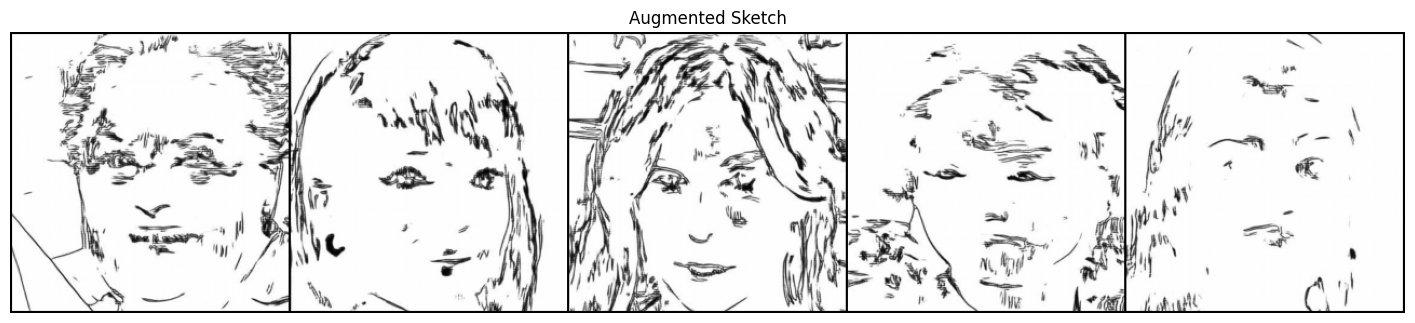

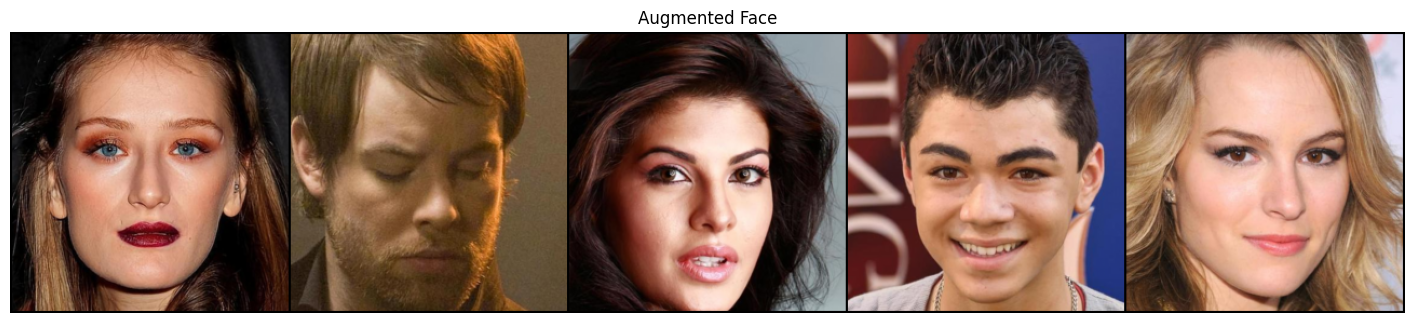

In [28]:
dm_sample = CustomDataModule(batch_size=5, **{k: v for k, v in DM_CONFIG.items() if k != "batch_size"})
dm_sample.setup("fit")

train_loader = dm_sample.train_dataloader()
imgs = next(iter(train_loader))

print("Shape of sketch images:", imgs[0]["sketch"].shape)
print("Shape of face images:", imgs[0]["face"].shape)


show_img(imgs[0]["sketch"], nrow=5, title="Augmented Sketch")
show_img(imgs[0]["face"], nrow=5, title="Augmented Face")

---

# 2. Building cGAN Architecture

### Downsampling blocks.

In [29]:
import torch
import torch.nn as nn

class Downsampling(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=4,
        stride=2,
        padding=1,
        norm=True,
        lrelu=True,
    ):
        super().__init__()
        # Prepare the list of modules to include in the sequential block
        modules = [
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=not norm)
        ]
        if norm:
            # InstanceNorm2d is added if norm is True
            modules.append(nn.InstanceNorm2d(out_channels, affine=True))
        if lrelu is not None:
            # LeakyReLU is added if lrelu is True, otherwise ReLU is added
            modules.append(nn.LeakyReLU(0.2, inplace=True) if lrelu else nn.ReLU(inplace=True))
        
        # Initialize the sequential block with the prepared list of modules
        self.block = nn.Sequential(*modules)
        
    def forward(self, x):
        return self.block(x)


### Upsampling blocks.

In [30]:
import torch
import torch.nn as nn

class Upsampling(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=4,
        stride=2,
        padding=1,
        output_padding=0,
        dropout=False,
    ):
        super().__init__()
        # Initialize the list with the ConvTranspose2d and InstanceNorm2d layers
        modules = [
            nn.ConvTranspose2d(in_channels, out_channels, 
                               kernel_size=kernel_size, stride=stride, 
                               padding=padding, output_padding=output_padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True)
        ]

        # Conditionally add dropout layer
        if dropout:
            modules.append(nn.Dropout(0.5))

        # Add the activation layer to the list
        modules.append(nn.ReLU(inplace=True))

        # Create the sequential block using the list of modules
        self.block = nn.Sequential(*modules)
        
    def forward(self, x):
        return self.block(x)


### Residual blocks.

In [31]:
import torch
import torch.nn as nn

class ResBlock(nn.Module):
    def __init__(self, in_channels, kernel_size=3, padding=1):
        super().__init__()
        # Use a more descriptive name for the sequential block
        self.residual_layers = nn.Sequential(
            nn.ReflectionPad2d(padding),  # Padding to keep feature map size consistent
            # Using Downsampling here may be misleading if the intention is not to reduce spatial dimensions
            nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=1, padding=0),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),  # First ReLU activation

            nn.ReflectionPad2d(padding),
            # Final Conv layer in the block without an activation function before the addition operation
            nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=1, padding=0),
            nn.InstanceNorm2d(in_channels)
        )
        
    def forward(self, x):
        # Apply the transformations and add the original input (skip connection)
        residual = self.residual_layers(x)
        return x + residual


### Building the generator.

In [32]:
class Generator(nn.Module):
    def __init__(self, hid_channels, in_channels, out_channels):
        super().__init__()
        self.downsampling_path = nn.Sequential(
            Downsampling(in_channels, hid_channels, norm=False), # 64x128x128
            Downsampling(hid_channels, hid_channels*2), # 128x64x64
            Downsampling(hid_channels*2, hid_channels*4), # 256x32x32
            Downsampling(hid_channels*4, hid_channels*8), # 512x16x16
            Downsampling(hid_channels*8, hid_channels*8), # 512x8x8
            Downsampling(hid_channels*8, hid_channels*8), # 512x4x4
            Downsampling(hid_channels*8, hid_channels*8), # 512x2x2
            Downsampling(hid_channels*8, hid_channels*8, norm=False), # 512x1x1, instance norm does not work on 1x1
        )
        self.upsampling_path = nn.Sequential(
            Upsampling(hid_channels*8, hid_channels*8, dropout=True), # (512+512)x2x2
            Upsampling(hid_channels*16, hid_channels*8, dropout=True), # (512+512)x4x4
            Upsampling(hid_channels*16, hid_channels*8, dropout=True), # (512+512)x8x8
            Upsampling(hid_channels*16, hid_channels*8), # (512+512)x16x16
            Upsampling(hid_channels*16, hid_channels*4), # (256+256)x32x32
            Upsampling(hid_channels*8, hid_channels*2), # (128+128)x64x64
            Upsampling(hid_channels*4, hid_channels), # (64+64)x128x128
        )
        self.feature_block = nn.Sequential(
            nn.ConvTranspose2d(hid_channels*2, out_channels,
                               kernel_size=4, stride=2, padding=1), # 3x256x256
            nn.Tanh(),
        )
        
    def forward(self, x):
        skips = []
        for down in self.downsampling_path:
            x = down(x)
            skips.append(x)
        skips = reversed(skips[:-1])

        for up, skip in zip(self.upsampling_path, skips):
            x = up(x)
            x = torch.cat([x, skip], dim=1)
        return self.feature_block(x)
    
class ResNetGenerator(nn.Module):
    def __init__(self, hid_channels, in_channels, out_channels, num_resblocks):
        super().__init__()
        self.model = nn.Sequential(
            # downsampling path
            nn.ReflectionPad2d(3),
            Downsampling(in_channels, hid_channels,
                         kernel_size=7, stride=1, padding=0, lrelu=False), # 64x256x256
            Downsampling(hid_channels, hid_channels*2, kernel_size=3, lrelu=False), # 128x128x128
            Downsampling(hid_channels*2, hid_channels*4, kernel_size=3, lrelu=False), # 256x64x64
            
            # residual blocks
            *[ResBlock(hid_channels*4) for _ in range(num_resblocks)], # 256x64x64
            
            # upsampling path
            Upsampling(hid_channels*4, hid_channels*2, kernel_size=3, output_padding=1), # 128x128x128
            Upsampling(hid_channels*2, hid_channels, kernel_size=3, output_padding=1), # 64x256x256
            nn.ReflectionPad2d(3),
            nn.Conv2d(hid_channels, out_channels, kernel_size=7, stride=1, padding=0), # 3x256x256
            nn.Tanh(),
        )
        
    def forward(self, x):
        return self.model(x)
    
def get_gen(gen_name, hid_channels, num_resblocks, in_channels=3, out_channels=3):
    if gen_name == "unet":
        return Generator(hid_channels, in_channels, out_channels)
    elif gen_name == "resnet":
        return ResNetGenerator(hid_channels, in_channels, out_channels, num_resblocks)
    else:
        raise NotImplementedError(f"Generator name '{gen_name}' not recognized.")

### Building the discriminator.

In [33]:
class Discriminator(nn.Module):
    def __init__(self, hid_channels, in_channels=3):
        super().__init__()
        self.block = nn.Sequential(
            Downsampling(in_channels, hid_channels, norm=False), # 64x128x128
            Downsampling(hid_channels, hid_channels*2), # 128x64x64
            Downsampling(hid_channels*2, hid_channels*4), # 256x32x32
            Downsampling(hid_channels*4, hid_channels*8, stride=1), # 512x31x31
            nn.Conv2d(hid_channels*8, 1, kernel_size=4, padding=1), # 1x30x30
        )
        
    def forward(self, x):
        return self.block(x)

In [34]:
def check_discriminator():
    # Example input tensor with batch size 5 and 3 channels (e.g., RGB images of size 256x256)
    x = torch.randn(5, 3, 256, 256)
    discriminator = Discriminator(hid_channels=64, in_channels=3)
    output = discriminator(x)
    print("Output shape of discriminator:", output.shape)

check_discriminator()

Output shape of discriminator: torch.Size([5, 1, 30, 30])


### Image buffer.

In [35]:
class ImageBuffer(object):
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        if self.buffer_size > 0:
            # the current capacity of the buffer
            self.curr_cap = 0
            # initialize buffer as empty list
            self.buffer = []
    
    def __call__(self, imgs):
        # the buffer is not used
        if self.buffer_size == 0:
            return imgs
        
        return_imgs = []
        for img in imgs:
            img = img.unsqueeze(dim=0)
            
            # fill buffer to maximum capacity
            if self.curr_cap < self.buffer_size:
                self.curr_cap += 1
                self.buffer.append(img)
                return_imgs.append(img)
            else:
                p = np.random.uniform(low=0., high=1.)
                
                # swap images between input and buffer with probability 0.5
                if p > 0.5:
                    idx = np.random.randint(low=0, high=self.buffer_size)
                    tmp = self.buffer[idx].clone()
                    self.buffer[idx] = img
                    return_imgs.append(tmp)
                else:
                    return_imgs.append(img)
        return torch.cat(return_imgs, dim=0)

### cGAN.

In [36]:
MODEL_CONFIG = {
    # the type of generator, and the number of residual blocks if ResNet generator is used
    "gen_name": "unet", # types: 'unet', 'resnet'
    "num_resblocks": 6,
    
    # the number of filters in the first layer for the generators and discriminators
    "hid_channels": 64,
    
    # using DeepSpeed's FusedAdam (currently GPU only) is slightly faster
    "optimizer": ds.ops.adam.FusedAdam if torch.cuda.is_available() else torch.optim.Adam,
    
    # the learning rate and beta parameters for the Adam optimizer
    "lr": 2e-4,
    "betas": (0.5, 0.999),
    
    # the weights used in the identity loss and cycle loss
    "lambda_idt": 0.5,
    "lambda_cycle": (10, 10), # (MPM direction, PMP direction)
    
    # the size of the buffer that stores previously generated images
    "buffer_size": 100,
    
    # the number of epochs for training
    "num_epochs": 2 if not DEBUG else 2,
    
    # the number of epochs before starting the learning rate decay
    "decay_epochs": 2 if not DEBUG else 1,
}

In [37]:
class cGAN(L.LightningModule):
    def __init__(
        self,
        gen_name,
        num_resblocks,
        hid_channels,
        optimizer,
        lr,
        betas,
        lambda_idt,
        lambda_cycle,
        buffer_size,
        num_epochs,
        decay_epochs,
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["optimizer"])
        self.optimizer = optimizer
        self.automatic_optimization = False
        
        # define generators and discriminators
        self.gen_SF = get_gen(gen_name, hid_channels, num_resblocks)
        self.gen_FS = get_gen(gen_name, hid_channels, num_resblocks)
        self.disc_F = Discriminator(hid_channels)
        self.disc_S = Discriminator(hid_channels)
        
        # initialize buffers to store fake images
        self.buffer_fake_F = ImageBuffer(buffer_size)
        self.buffer_fake_S = ImageBuffer(buffer_size)
        
        self.ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
        self.psnr = PeakSignalNoiseRatio(data_range=1.0)
        
    def forward(self, img):
        return self.gen_SF(img)   
            
    def init_weights(self):
        def init_fn(m):
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.InstanceNorm2d)):
                nn.init.normal_(m.weight, 0.0, 0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
        
        for net in [self.gen_SF, self.gen_FS, self.disc_F, self.disc_S]:
            net.apply(init_fn)
        
    def setup(self, stage):
        if stage == "fit":
            self.init_weights()
            print("Model initialized.")
            
    def get_lr_scheduler(self, optimizer):
        def lr_lambda(epoch):
            len_decay_phase = self.hparams.num_epochs - self.hparams.decay_epochs + 1.0
            curr_decay_step = max(0, epoch - self.hparams.decay_epochs + 1.0)
            val = 1.0 - curr_decay_step / len_decay_phase
            return max(0.0, val)
        
        return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
    
    def configure_optimizers(self):
        opt_config = {
            "lr": self.hparams.lr,
            "betas": self.hparams.betas,
        }
        opt_gen = self.optimizer(
            list(self.gen_SF.parameters()) + list(self.gen_FS.parameters()),
            **opt_config,
        )
        opt_disc = self.optimizer(
            list(self.disc_F.parameters()) + list(self.disc_S.parameters()),
            **opt_config,
        )
        optimizers = [opt_gen, opt_disc]
        schedulers = [self.get_lr_scheduler(opt) for opt in optimizers]
        return optimizers, schedulers
        
    def adv_criterion(self, y_hat, y):
        return F.mse_loss(y_hat, y)
    
    def recon_criterion(self, y_hat, y):
        return F.l1_loss(y_hat, y)
    
    def get_adv_loss(self, fake, disc):
        fake_hat = disc(fake)
        real_labels = torch.ones_like(fake_hat)
        adv_loss = self.adv_criterion(fake_hat, real_labels)
        return adv_loss
    
    def get_idt_loss(self, real, idt, lambda_cycle):
        idt_loss = self.recon_criterion(idt, real)
        return self.hparams.lambda_idt * lambda_cycle * idt_loss
    
    def get_cycle_loss(self, real, recon, lambda_cycle):
        cycle_loss = self.recon_criterion(recon, real)
        return lambda_cycle * cycle_loss
    
    def get_gen_loss(self):
        # calculate adversarial loss
        adv_loss_SF = self.get_adv_loss(self.fake_F, self.disc_F)
        adv_loss_FS = self.get_adv_loss(self.fake_S, self.disc_S)
        total_adv_loss = adv_loss_SF + adv_loss_FS
        
        # calculate identity loss
        lambda_cycle = self.hparams.lambda_cycle
        idt_loss_FF = self.get_idt_loss(self.real_F, self.idt_F, lambda_cycle[0])
        idt_loss_SS = self.get_idt_loss(self.real_S, self.idt_S, lambda_cycle[1])
        total_idt_loss = idt_loss_FF + idt_loss_SS
        
        # calculate cycle loss
        cycle_loss_FSF = self.get_cycle_loss(self.real_F, self.recon_F, lambda_cycle[0])
        cycle_loss_SFS = self.get_cycle_loss(self.real_S, self.recon_S, lambda_cycle[1])
        total_cycle_loss = cycle_loss_FSF + cycle_loss_SFS
        
        # combine losses
        gen_loss = total_adv_loss + total_idt_loss + total_cycle_loss
        return gen_loss
    
    def get_disc_loss(self, real, fake, disc):
        # calculate loss on real images
        real_hat = disc(real)
        real_labels = torch.ones_like(real_hat)
        real_loss = self.adv_criterion(real_hat, real_labels)
        
        # calculate loss on fake images
        fake_hat = disc(fake.detach())
        fake_labels = torch.zeros_like(fake_hat)
        fake_loss = self.adv_criterion(fake_hat, fake_labels)
        
        # combine losses
        disc_loss = (fake_loss + real_loss) * 0.5
        return disc_loss
    
    def get_disc_loss_F(self):
        fake_F = self.buffer_fake_F(self.fake_F)
        return self.get_disc_loss(self.real_F, fake_F, self.disc_F)
    
    def get_disc_loss_S(self):
        fake_S = self.buffer_fake_S(self.fake_S)
        return self.get_disc_loss(self.real_S, fake_S, self.disc_S)
    
    def get_SSIM(self, img1, img2):
        return self.ssim(img1, img2)
    
    def get_PSNR(self, img1, img2):
        return self.psnr(img1, img2)
    
    def training_step(self, batch, batch_idx):
        self.real_S = batch["sketch"]
        self.real_F = batch["face"]
        opt_gen, opt_disc = self.optimizers()

        # generate fake images
        self.fake_F = self.gen_SF(self.real_S)
        self.fake_S = self.gen_FS(self.real_F)
        
        # generate identity images
        self.idt_F = self.gen_SF(self.real_F)
        self.idt_S = self.gen_FS(self.real_S)
        
        # reconstruct images
        self.recon_F = self.gen_SF(self.fake_S)
        self.recon_S = self.gen_FS(self.fake_F)
    
        # train generators
        self.toggle_optimizer(opt_gen)
        gen_loss = self.get_gen_loss()        
        opt_gen.zero_grad()
        self.manual_backward(gen_loss)
        opt_gen.step()
        self.untoggle_optimizer(opt_gen)
        
        # train discriminators
        self.toggle_optimizer(opt_disc)
        disc_loss_F = self.get_disc_loss_F()
        disc_loss_S = self.get_disc_loss_S()
        opt_disc.zero_grad()
        self.manual_backward(disc_loss_F)
        self.manual_backward(disc_loss_S)
        opt_disc.step()
        self.untoggle_optimizer(opt_disc)
        
        ssim_F = self.get_SSIM(self.real_F, self.fake_F)
        ssim_S = self.get_SSIM(self.real_S, self.fake_S)
        
        psnr_F = self.get_PSNR(self.real_F, self.fake_F)
        psnr_S = self.get_PSNR(self.real_S, self.fake_S)
        # record training losses
        metrics = {
            "gen_loss": gen_loss,
            "disc_loss_F": disc_loss_F,
            "disc_loss_S": disc_loss_S,
            "SSIM_F": ssim_F,
            "SSIM_S": ssim_S,
            "PSNR_F": psnr_F,
            "PSNR_S": psnr_S,
        }
        self.log_dict(metrics, on_step=False, on_epoch=True, prog_bar=True)
        if not hasattr(self, 'losses'):
            self.losses = {'gen_loss': [], 'disc_loss_F': [], 'disc_loss_S': []}
        self.losses['gen_loss'].append(gen_loss.item())
        self.losses['disc_loss_F'].append(disc_loss_F.item())
        self.losses['disc_loss_S'].append(disc_loss_S.item())
        
    def validation_step(self, batch, batch_idx):
        self.real_S = batch["sketch"]
        self.real_F = batch["face"]

        # generate fake images
        self.fake_F = self.gen_SF(self.real_S)
        self.fake_S = self.gen_FS(self.real_F)
        
        ssim_F = self.get_SSIM(self.real_F, self.fake_F)
        ssim_S = self.get_SSIM(self.real_S, self.fake_S)
        
        psnr_F = self.get_PSNR(self.real_F, self.fake_F)
        psnr_S = self.get_PSNR(self.real_S, self.fake_S)
        # record training losses
        metrics_val = {
            "SSIM_F_val": ssim_F,
            "SSIM_S_val": ssim_S,
            "PSNR_F_val": psnr_F,
            "PSNR_S_val": psnr_S,
        }
        self.log_dict(metrics_val, on_step=False, on_epoch=True, prog_bar=True)
        #self.display_results(batch, batch_idx, "validate")
    
    def test_step(self, batch, batch_idx):
        self.display_results(batch, batch_idx, "test")
        
    def predict_step(self, batch, batch_idx):
        return self(batch)
    
    def display_results(self, batch, batch_idx, stage):
        real_S = batch
        fake_F = self(real_S)
        
        if stage == "validate":
            title = f"Epoch {self.current_epoch+1}: Sketch-to-Face Translation"
        else:
            title = f"Sample {batch_idx+1}: Sketch-to-Face Translation"

        show_img(
            torch.cat([real_S, fake_F], dim=0),
            nrow=len(real_S),
            title=title,
        )
    
    def on_train_epoch_start(self):
        # record learning rates
        curr_lr = self.lr_schedulers()[0].get_last_lr()[0]
        self.log("lr", curr_lr, on_step=False, on_epoch=True, prog_bar=True)
        
    def on_train_epoch_end(self):
    # Update learning rates
        for sch in self.lr_schedulers():
            sch.step()

        # Print current state of epoch
        logged_train = self.trainer.callback_metrics
        train_metrics = {k: v for k, v in logged_train.items() if 'val' not in k}

        # Print training metrics first
        print(
            f"Train - Epoch {self.current_epoch+1}",
            *[f"{k}: {v:.5f}" for k, v in train_metrics.items()],
            sep=" - ",
        )

        # Print validation metrics after
        val_metrics = {k: v for k, v in logged_train.items() if 'val' in k}
        print(
            f"Validation - Epoch {self.current_epoch+1}",
            *[f"{k}: {v:.5f}" for k, v in val_metrics.items()],
            sep=" - ",
        )
        
    def on_train_end(self):
        print("Training ended.")
        
    def on_predict_epoch_end(self):
        predictions = self.trainer.predict_loop.predictions
        num_batches = len(predictions)
        batch_size = predictions[0].shape[0]
        last_batch_diff = batch_size - predictions[-1].shape[0]
        print(f"Number of images generated: {num_batches*batch_size-last_batch_diff}.")

---

# 3. Model Training

In [38]:
TRAIN_CONFIG = {
    "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
    
    # train on 16-bit precision
    "precision": "16-mixed" if torch.cuda.is_available() else 32,
    
    # train on single GPU
    "devices": 1,
    
    # save checkpoint only for last epoch by default
    "enable_checkpointing": True,
    
    # disable logging for simplicity
    "logger": False,
    
    # the number of epochs for training (we limit the number of train/predict batches during debugging)
    "max_epochs": MODEL_CONFIG["num_epochs"],
    "limit_train_batches": 1.0 if not DEBUG else 2,
    "limit_predict_batches": 1.0 if not DEBUG else 5,
    
    # the maximum amount of time for training, in case we exceed run-time of 5 hours
    "max_time": {"hours": 11, "minutes": 55},
    
    # use a small subset of photos for validation/testing (we limit here for flexibility)
    "limit_val_batches": 1,
    "limit_test_batches": 5,
    
    # disable sanity check before starting the training routine
    "num_sanity_val_steps": 0,
    
    # the frequency to visualize the progress of adding Monet style
    "check_val_every_n_epoch": 1 if not DEBUG else 1,
}

In [ ]:
dm = CustomDataModule(**DM_CONFIG)
model = cGAN(**MODEL_CONFIG)
trainer = L.Trainer(**TRAIN_CONFIG)

trainer.fit(model, datamodule=dm)

Model initialized.


Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py310_cu121/fused_adam...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/fused_adam/build.ninja...
Building extension module fused_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] /usr/local/cuda/bin/nvcc  -DTORCH_EXTENSION_NAME=fused_adam -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1013\" -I/opt/conda/lib/python3.10/site-packages/deepspeed/ops/csrc/includes -I/opt/conda/lib/python3.10/site-packages/deepspeed/ops/csrc/adam -isystem /opt/conda/lib/python3.10/site-packages/torch/include -isystem /opt/conda/lib/python3.10/site-packages/torch/include/torch/csrc/api/include -isystem /opt/conda/lib/python3.10/site-packages/torch/include/TH -isystem /opt/conda/lib/python3.10/site-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /opt/conda/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=1 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_60,code=compute_60 -gencode=arch=compute_60,code=sm_60 --compiler-options '-fPIC' -O3 -DVERSION_GE_1_1 -DVERS

Loading extension module fused_adam...
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Train - Epoch 1 - lr: 0.00020 - gen_loss: 9.58885 - disc_loss_F: 0.09307 - disc_loss_S: 0.09219 - SSIM_F: -0.06121 - SSIM_S: -0.10917 - PSNR_F: 0.85411 - PSNR_S: -0.68354
Validation - Epoch 1 - SSIM_F_val: -0.14220 - SSIM_S_val: -0.24423 - PSNR_F_val: -1.04844 - PSNR_S_val: -2.12231


Validation: |          | 0/? [00:00<?, ?it/s]

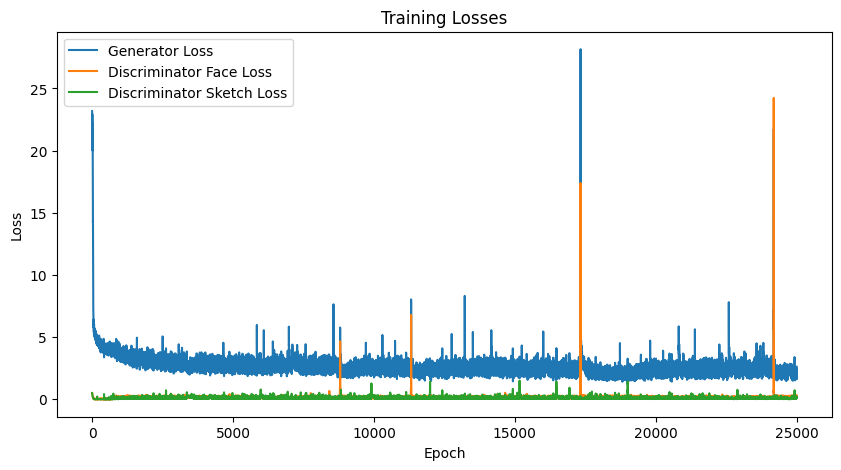

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(model.losses['gen_loss'], label='Generator Loss')
plt.plot(model.losses['disc_loss_F'], label='Discriminator Face Loss')
plt.plot(model.losses['disc_loss_S'], label='Discriminator Sketch Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Losses')
plt.show()

In [ ]:
model_path = "cGAN_model.pth"
torch.save(model.state_dict(), model_path)

print(f"Model saved at {model_path}")

In [ ]:
model = cGAN(**MODEL_CONFIG)
model.load_state_dict(torch.load("/kaggle/input/my-model/cGAN_model.pth"))

# Check if CUDA is available and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

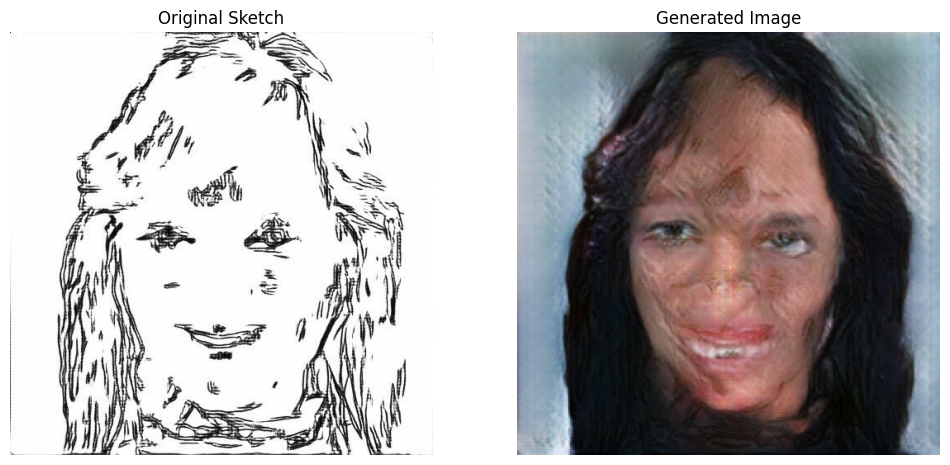

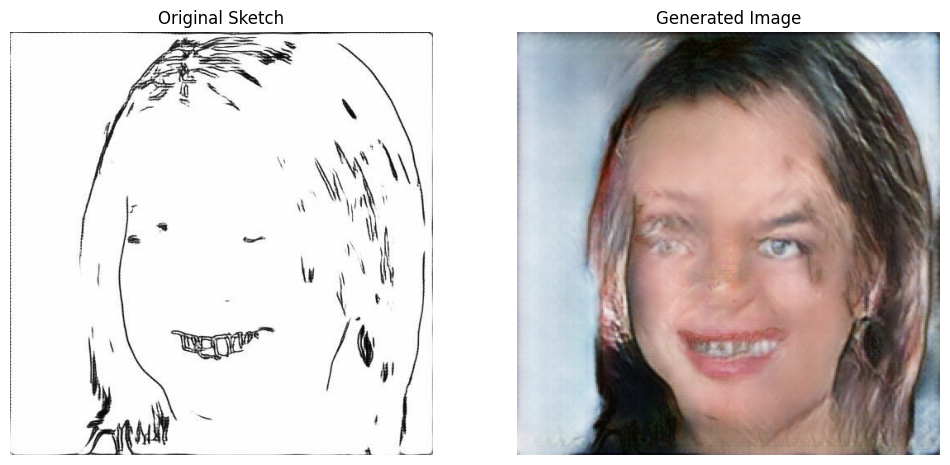

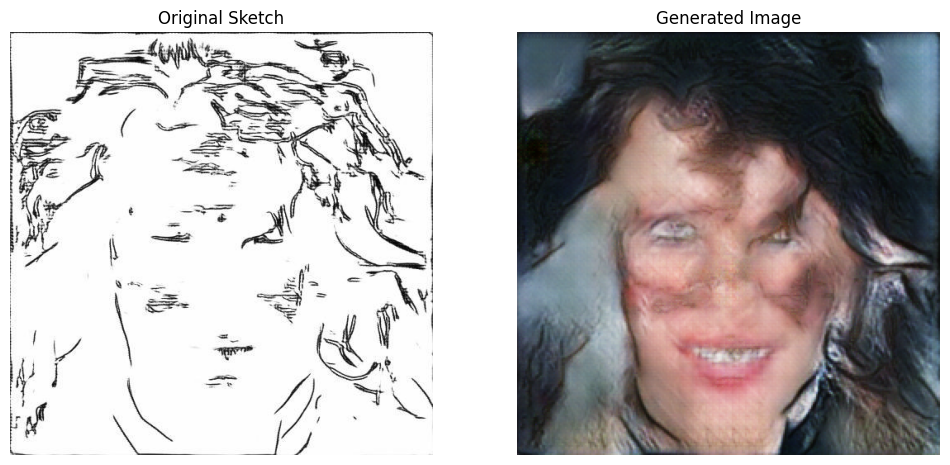

In [48]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to the expected input size
    transforms.ToTensor(),  # Convert image to tensor
    lambda x: x * 2 - 1  # Normalize the image to range [-1, 1] as done in training
])

# Path to the sketches directory
sketch_dir = '/kaggle/working/person-face-sketch/test/sketches'
sketch_files = os.listdir(sketch_dir)
sketch_files.sort()  # Ensure files are in a predictable order if needed

# Iterate over the first three images
for sketch_file in sketch_files[:3]:
    sketch_path = os.path.join(sketch_dir, sketch_file)
    sketch_image = Image.open(sketch_path).convert('RGB')  # Ensure image is in RGB
    sketch_tensor = transform(sketch_image).unsqueeze(0)  # Add a batch dimension
    sketch_tensor = sketch_tensor.to(device)

    # Generate the image
    with torch.no_grad():
        generated_image_tensor = model.gen_SF(sketch_tensor)

    # Normalize the output image for display
    generated_image_tensor = ((generated_image_tensor.squeeze(0) + 1) / 2).clamp(0, 1)
    generated_image = transforms.ToPILImage()(generated_image_tensor.cpu())

    # Display the original sketch and the generated image side by side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(sketch_image)
    ax[0].set_title('Original Sketch')
    ax[0].axis('off')

    ax[1].imshow(generated_image)
    ax[1].set_title('Generated Image')
    ax[1].axis('off')

    plt.show()